In [2]:
# imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline
plt.style.use('dark_background')

%load_ext autoreload

%autoreload 2

In [3]:
# get asap data
data_folder = Path.cwd().parent.parent.joinpath('data', 'external')
df_asap = pd.read_csv(Path(data_folder).joinpath('asap','region',
                                                 'SEN_asap_region.csv'), index_col = 0)


In [11]:
# get IPC data
df_ipc = pd.read_csv(Path(data_folder).joinpath('ipc_current.csv'))

In [12]:
df_ipc.head()

,adm1_name,adm2_name,datetime,population,phase_class,phase1,phase2,phase3,phase4,phase5,phase35
0,Kolda,Velingara,2014-01-01,289381.0,2.0,208354.0,57876.0,23150.0,0.0,0.0,23150.0
1,Kolda,Kolda,2014-01-01,249271.0,2.0,184461.0,47361.0,17449.0,0.0,0.0,17449.0
2,Kolda,Medina Yoro Foulah,2014-01-01,134688.0,2.0,106404.0,21550.0,6734.0,0.0,0.0,6734.0
3,Louga,Louga,2014-01-01,387594.0,3.0,135658.0,174417.0,62015.0,15504.0,0.0,77519.0
4,Louga,Linguere,2014-01-01,258325.0,2.0,206660.0,36166.0,15500.0,0.0,0.0,15500.0


In [13]:
df_ipc['datetime'].unique()

array(['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
       '2018-01-01', '2019-01-01', '2020-01-01', '2014-09-01',
       '2015-09-01', '2016-09-01', '2017-09-01', '2018-09-01',
       '2019-09-01', '2020-09-01'], dtype=object)

### First start looking at the ratio between population share in different Phases

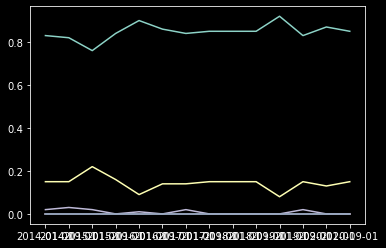

In [14]:
# for one region
temp = df_ipc[df_ipc['adm2_name'] == 'Thies'].copy()
temp.sort_values('datetime', inplace = True)
plt.plot(temp['datetime'], temp['phase1']/temp['population'])
plt.plot(temp['datetime'], temp['phase2']/temp['population'])
plt.plot(temp['datetime'], temp['phase3']/temp['population'])
plt.plot(temp['datetime'], temp['phase4']/temp['population'])
plt.plot(temp['datetime'], temp['phase5']/temp['population'])

#regions  = df_ipc['adm1_name'].unique()

We don't know yet, what to conclude from this.

We are probably going to predict something like softmax for 5 classes.

In [15]:
df_ipc.head()

,adm1_name,adm2_name,datetime,population,phase_class,phase1,phase2,phase3,phase4,phase5,phase35
0,Kolda,Velingara,2014-01-01,289381.0,2.0,208354.0,57876.0,23150.0,0.0,0.0,23150.0
1,Kolda,Kolda,2014-01-01,249271.0,2.0,184461.0,47361.0,17449.0,0.0,0.0,17449.0
2,Kolda,Medina Yoro Foulah,2014-01-01,134688.0,2.0,106404.0,21550.0,6734.0,0.0,0.0,6734.0
3,Louga,Louga,2014-01-01,387594.0,3.0,135658.0,174417.0,62015.0,15504.0,0.0,77519.0
4,Louga,Linguere,2014-01-01,258325.0,2.0,206660.0,36166.0,15500.0,0.0,0.0,15500.0


In [16]:
df_ipc.drop(['adm1_name', 'phase_class'], axis=1, inplace=True)

In [17]:
# severity version 2
df_ipc['severity'] = (df_ipc['phase1'] + df_ipc['phase2']*2
                          + df_ipc['phase3']*4 + df_ipc['phase4']*8 +
                          df_ipc['phase5']*16 )/ df_ipc['population']

In [18]:
df_ipc.head()

,adm2_name,datetime,population,phase1,phase2,phase3,phase4,phase5,phase35,severity
0,Velingara,2014-01-01,289381.0,208354.0,57876.0,23150.0,0.0,0.0,23150.0,1.439991
1,Kolda,2014-01-01,249271.0,184461.0,47361.0,17449.0,0.0,0.0,17449.0,1.399998
2,Medina Yoro Foulah,2014-01-01,134688.0,106404.0,21550.0,6734.0,0.0,0.0,6734.0,1.309990
3,Louga,2014-01-01,387594.0,135658.0,174417.0,62015.0,15504.0,0.0,77519.0,2.210003
4,Linguere,2014-01-01,258325.0,206660.0,36166.0,15500.0,0.0,0.0,15500.0,1.320012


In [19]:
cols = list(df_ipc.columns)
cols[0] = 'unit_name'
df_ipc.columns = cols

In [20]:
df_ipc.head()

,unit_name,datetime,population,phase1,phase2,phase3,phase4,phase5,phase35,severity
0,Velingara,2014-01-01,289381.0,208354.0,57876.0,23150.0,0.0,0.0,23150.0,1.439991
1,Kolda,2014-01-01,249271.0,184461.0,47361.0,17449.0,0.0,0.0,17449.0,1.399998
2,Medina Yoro Foulah,2014-01-01,134688.0,106404.0,21550.0,6734.0,0.0,0.0,6734.0,1.309990
3,Louga,2014-01-01,387594.0,135658.0,174417.0,62015.0,15504.0,0.0,77519.0,2.210003
4,Linguere,2014-01-01,258325.0,206660.0,36166.0,15500.0,0.0,0.0,15500.0,1.320012


In [21]:
df_ipc.sort_values('datetime', inplace=True)


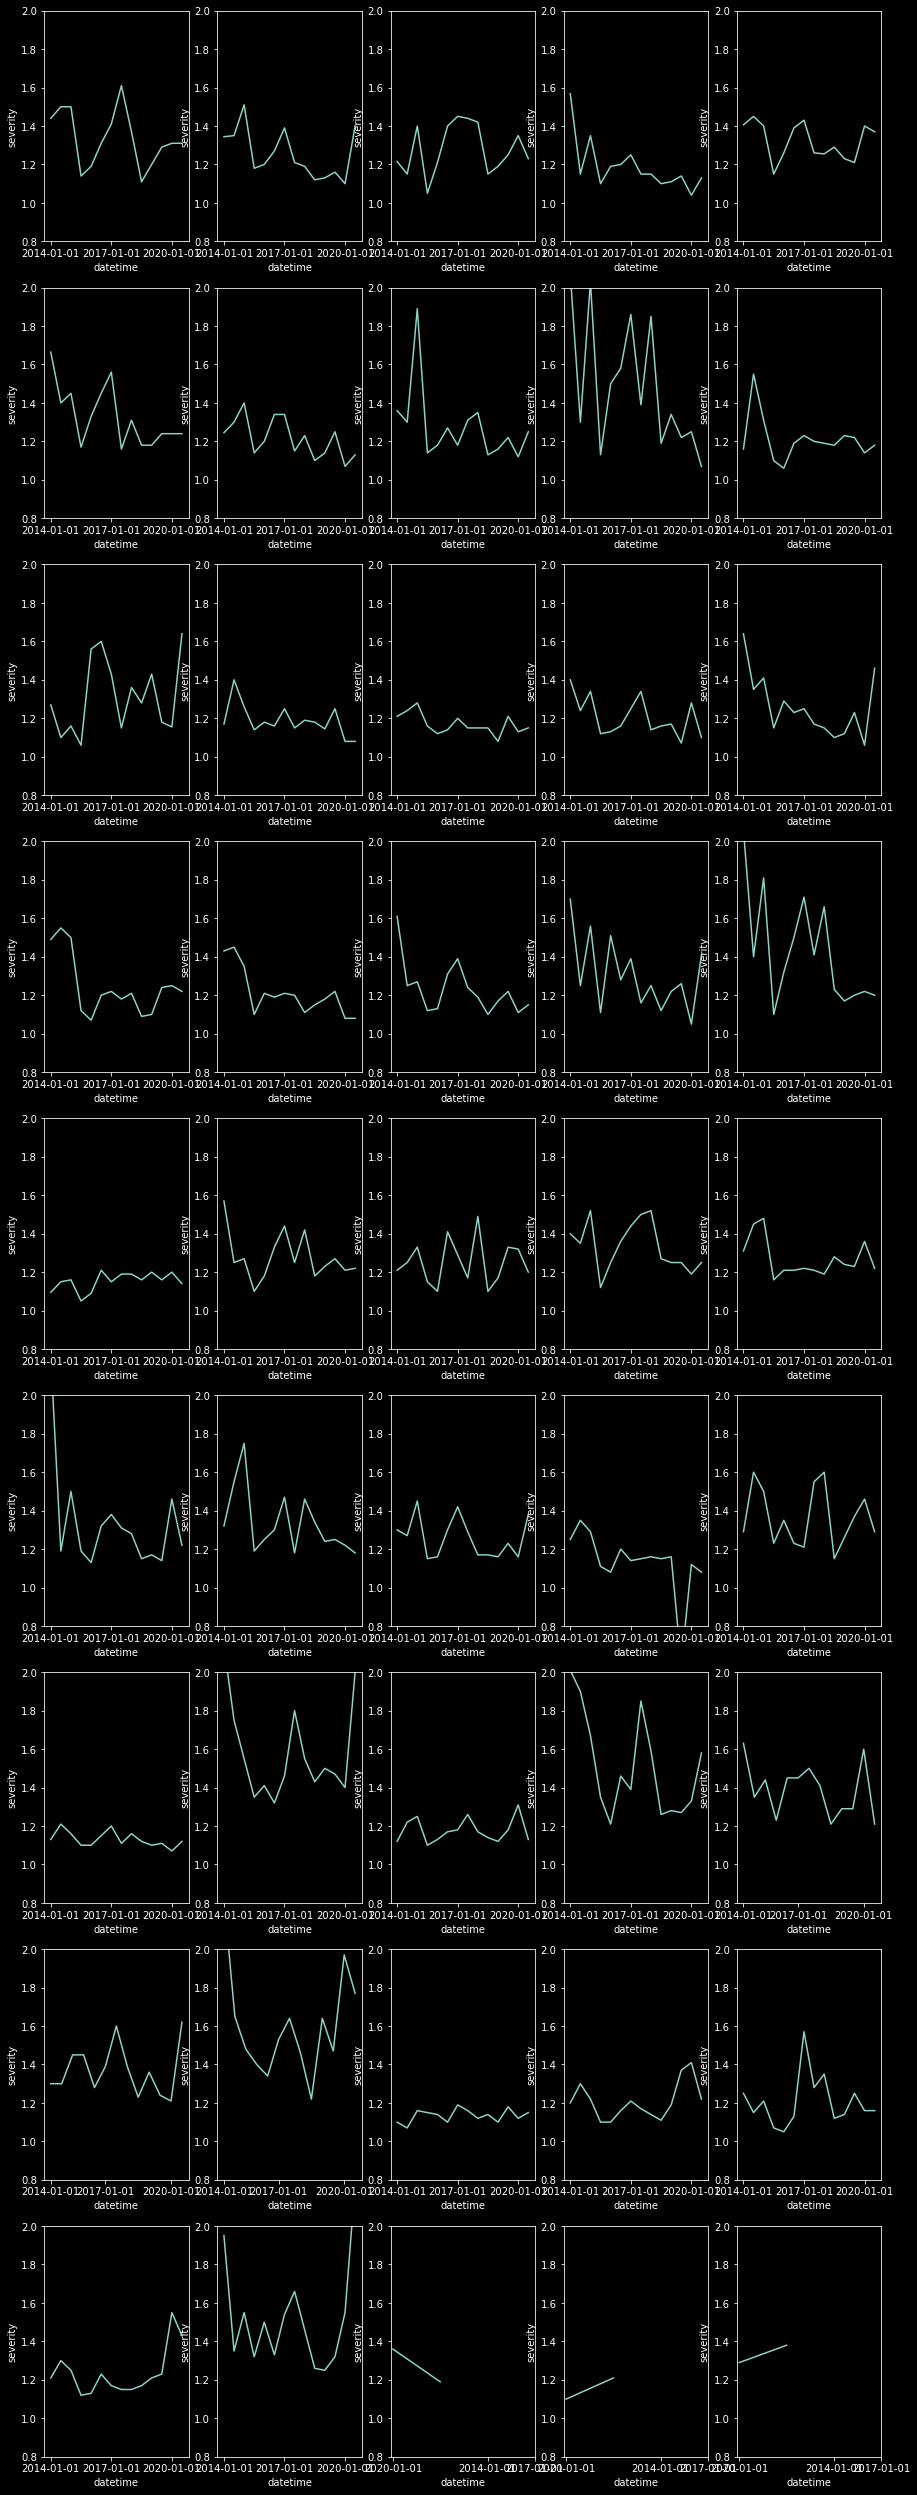

In [22]:
xtics = df_ipc['datetime'].unique()[::6]
units = df_ipc['unit_name'].unique()
fig, ax  = plt.subplots(9,5, figsize = (15, 45))
ax = ax.flatten()
for i in range(len(units)):
    sns.lineplot(data = df_ipc[df_ipc['unit_name'] == units[i]],
                 x = 'datetime',
                 y = 'severity',
                 ax = ax[i])
    ax[i].set_xticks(xtics)
    ax[i].set_ylim(0.8, 2)

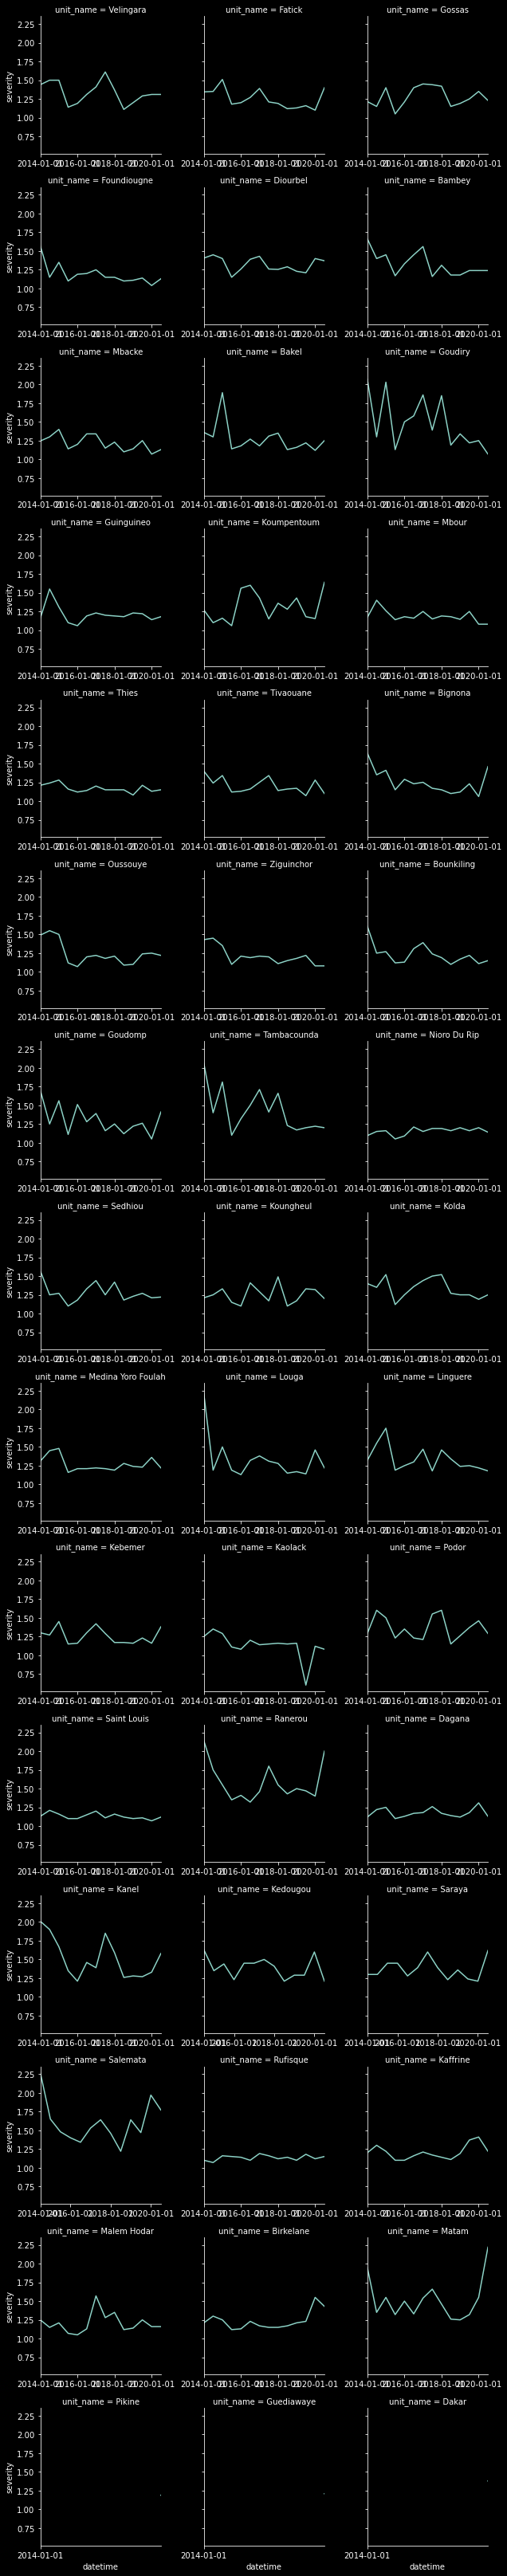

In [23]:
g = sns.FacetGrid(data = df_ipc, col_wrap=3, col='unit_name', sharex=False)
xtics = df_ipc['datetime'].unique()
xtics.sort()

g.map(sns.lineplot, 'datetime','severity', sort=True)
g.set(xticks=xtics[::4], xlim=(xtics[0], xtics[-1]))

## Lets pick a distinguish region:
adepts:
- Kedougou
- Ranerou (Matam)
- Kanel

what about the weather data:

In [24]:
units = ['Kedougou', 'Ranerou', 'Kanel']

df_ipc[df_ipc['unit_name'] == 'Kedougou']

,unit_name,datetime,population,phase1,phase2,phase3,phase4,phase5,phase35,severity
12,Kedougou,2014-01-01,79532.0,45333.0,26246.0,7953.0,0.0,0.0,7953.0,1.629998
314,Kedougou,2014-09-01,78522.0,58892.0,15704.0,3926.0,0.0,0.0,3926.0,1.349991
59,Kedougou,2015-01-01,75853.0,54614.0,15171.0,6068.0,0.0,0.0,6068.0,1.439996
100,Kedougou,2016-01-01,83801.0,71231.0,9218.0,3352.0,0.0,0.0,3352.0,1.229997
391,Kedougou,2016-09-01,86589.0,56283.0,25977.0,4329.0,0.0,0.0,4329.0,1.449988
143,Kedougou,2017-01-01,89481.0,56373.0,29529.0,3579.0,0.0,0.0,3579.0,1.449995
434,Kedougou,2017-09-01,92484.0,55490.0,32369.0,4624.0,0.0,0.0,4624.0,1.499978
199,Kedougou,2018-01-01,89481.0,58163.0,28634.0,2684.0,0.0,0.0,2684.0,1.409986
463,Kedougou,2018-09-01,95599.0,81259.0,11472.0,2868.0,0.0,0.0,2868.0,1.210002
221,Kedougou,2019-01-01,95599.0,71699.0,21988.0,1912.0,0.0,0.0,1912.0,1.290003


In [25]:
temp.head()

,adm1_name,adm2_name,datetime,population,phase_class,phase1,phase2,phase3,phase4,phase5,phase35
34,Thies,Thies,2014-01-01,669764.0,1.0,555904.0,100465.0,13395.0,0.0,0.0,13395.0
335,Thies,Thies,2014-09-01,667814.0,1.0,547607.0,100172.0,20034.0,0.0,0.0,20034.0
80,Thies,Thies,2015-01-01,665770.0,2.0,505985.0,146469.0,13315.0,0.0,0.0,13315.0
374,Thies,Thies,2015-09-01,705317.0,1.0,592466.0,112851.0,0.0,0.0,0.0,0.0
122,Thies,Thies,2016-01-01,705317.0,1.0,634785.0,63479.0,7053.0,0.0,0.0,7053.0


In [26]:
temp = df_asap[df_asap['unit_name'] == units[0]]
temp = temp[temp['year']>=2012]

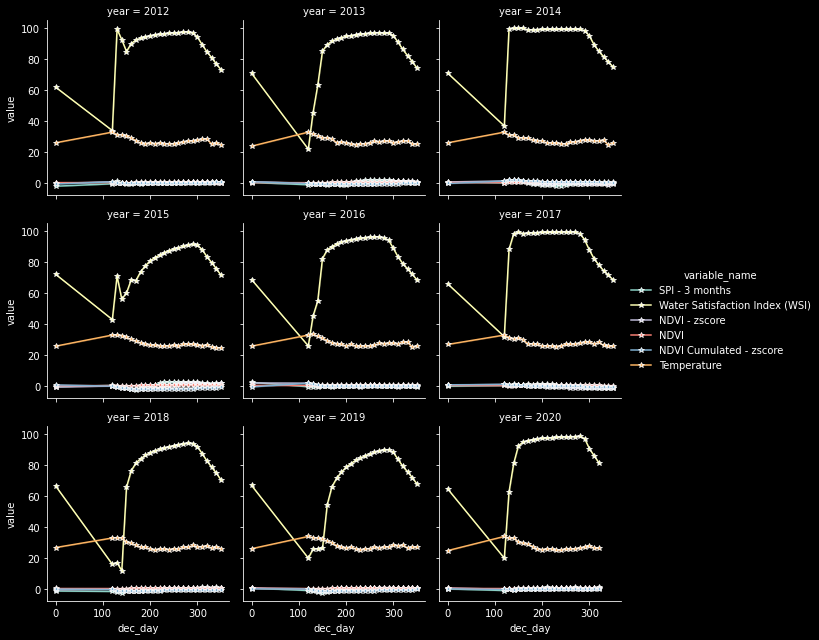

In [27]:
# per year
g = sns.FacetGrid(data = temp, col = 'year',hue = 'variable_name', col_wrap=3,
                  legend_out=True)
g.map(sns.lineplot, 'dec_day', 'value', marker='*')
g.add_legend()




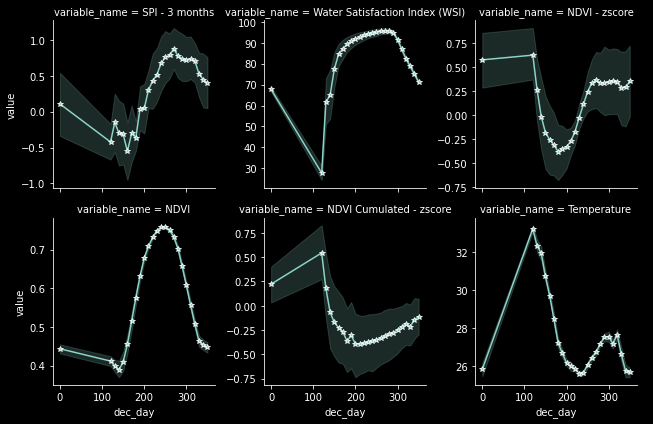

In [28]:
# with variance
g = sns.FacetGrid(data = temp, col = 'variable_name', col_wrap=3,
                  legend_out=True, sharey=False)
g.map(sns.lineplot, 'dec_day', 'value', marker='*')
g.add_legend()

In [29]:
temp['dec_day'].unique()

array([  0, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230,
       240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350])

So lets set the start of the year as 100 dec_day (to be sure).


We have ground truth from two time spans:
- Sep - Dec
- Jan - May

Most warnings are issued in months from Jun-November, this is when an anomaly happens.
The outcome might onset with a delay. Lets not separate the data, and look at the season
from the day 100 (approximately from May) and we will try to perdict the state
in Jan - May next year.

In [30]:

df_crop = temp[(temp['year'] >= 2012) & (temp['year'] <=2020)]


In [31]:
df_crop



,unit_name,variable_name,date,value,year,month,day,yearday,dec_day
22936,Kedougou,SPI - 3 months,20120101,-1.910,2012,1,1,1,0
22937,Kedougou,SPI - 3 months,20120501,-0.360,2012,5,1,122,120
22938,Kedougou,SPI - 3 months,20120511,1.271,2012,5,11,132,130
22939,Kedougou,SPI - 3 months,20120521,0.446,2012,5,21,142,140
22940,Kedougou,SPI - 3 months,20120601,-0.455,2012,6,1,153,150
...,...,...,...,...,...,...,...,...,...
25267,Kedougou,Temperature,20201011,26.535,2020,10,11,285,280
25268,Kedougou,Temperature,20201021,26.987,2020,10,21,295,290
25269,Kedougou,Temperature,20201101,27.984,2020,11,1,306,300
25270,Kedougou,Temperature,20201111,26.435,2020,11,11,316,310


In [32]:
start_season_day = 100
for i, row in df_crop.iterrows():
    y = int(row['year'])
    d = row['dec_day']
    df_crop.loc[i,'season_year'] = y if d > start_season_day else y-1
    df_crop.loc[i, 'season_dec_day'] = d-100 if d>start_season_day \
        else 360 - start_season_day+d

In [33]:
df_crop.head()

,unit_name,variable_name,date,value,year,month,day,yearday,dec_day,season_year,season_dec_day
22936,Kedougou,SPI - 3 months,20120101,-1.910,2012,1,1,1,0,2011.0,260.0
22937,Kedougou,SPI - 3 months,20120501,-0.360,2012,5,1,122,120,2012.0,20.0
22938,Kedougou,SPI - 3 months,20120511,1.271,2012,5,11,132,130,2012.0,30.0
22939,Kedougou,SPI - 3 months,20120521,0.446,2012,5,21,142,140,2012.0,40.0
22940,Kedougou,SPI - 3 months,20120601,-0.455,2012,6,1,153,150,2012.0,50.0


## Linear regression

$$y(w,x) = w_0 + w_1x_1 + ... w_px_p$$

In [34]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [35]:
df_crop['unit_name'].unique()

array(['Kedougou'], dtype=object)

In [36]:
df_ipc_unit = df_ipc[df_ipc['unit_name'] == 'Kedougou']

In [17]:
a = np.random.randint(0,10, 5)

In [22]:
a

array([0, 1, 3, 0, 3])

In [24]:
np.argsort(-a)[0]

2

In [ ]:
# select only current situation from Jan to May
gt1 = df_ipc_unit[df_ipc_unit['datetime'].apply(lambda x: x[5:7] == '01')].copy()

# just from curiosity, lets leave the current situation from Sep - Dec
gt2 = df_ipc_unit[df_ipc_unit['datetime'].apply(lambda x: x[5:7] == '09')].copy()

In [13]:
from difflib import SequenceMatcher

In [16]:
SequenceMatcher(None,['ahoj'], ['aahoj']).ratio()

0.0

In [ ]:
gt1['season'] = gt1['datetime'].apply(lambda x: int(x[:4])-1)

In [40]:
gt1 = gt1[['season', 'severity']]

In [41]:
gt1

,season,severity
12,2013,1.629998
59,2014,1.439996
100,2015,1.229997
143,2016,1.449995
199,2017,1.409986
221,2018,1.290003
265,2019,1.600024


In [42]:
y = gt1['severity'].values
seasons = gt1['season']

In [43]:
df_crop = df_crop[['variable_name', 'value', 'season_year', 'season_dec_day']]

In [44]:
df_crop = df_crop[df_crop['season_year'] != 2011.0]

In [45]:
df_crop.set_index(['season_year', 'season_dec_day'], inplace=True)

In [46]:
scaler = StandardScaler()

In [48]:
x = []
for i in seasons:
    x_sample = df_crop.xs(i).reset_index()
    x_sample.drop_duplicates(subset=['season_dec_day', 'variable_name'], inplace=True)
    x_sample = x_sample.pivot('season_dec_day','variable_name','value')
    sample_cols = x_sample.columns
    x_sample = x_sample.values
    x.append(x_sample)

In [49]:
x = np.array(x)

In [50]:
x.shape

(7, 25, 6)

In [51]:
xx = np.empty((7,150))
for i in range(7):
    xx[i] = x[i,:,:].T.flatten()

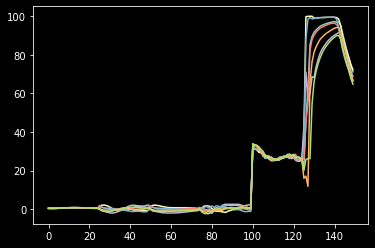

In [52]:
for i in range(7):
    plt.plot(xx[i])

In [53]:
scaler.fit(xx)
xx = scaler.transform(xx)

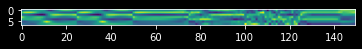

In [54]:
plt.imshow(xx)

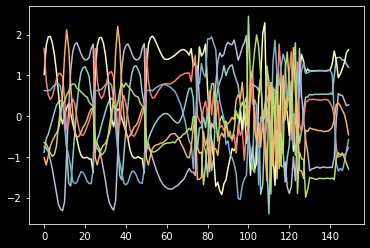

In [55]:
for i in range(7):
    plt.plot(xx[i])

In [56]:
regr = linear_model.LinearRegression()
regr.fit(xx[:-2,:], y[:-2])
yy = regr.predict([xx[-1,:]])
print(yy)

[1.33408326]


In [57]:
y[-1]

1.6000242826500466

In [58]:
y[0]

1.6299979882311522

In [59]:
clf = make_pipeline(StandardScaler(), linear_model.LinearRegression())
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_validate(clf, xx, y, cv=cv, scoring='neg_mean_squared_error')

{'fit_time': array([0.00534368, 0.00147772, 0.0013814 , 0.0012989 , 0.00128484]),
 'score_time': array([0.00072408, 0.0004847 , 0.00048685, 0.00045443, 0.00045371]),
 'test_score': array([-0.05283923, -0.0763491 , -0.03449844, -0.09963918, -0.12878203])}

In [60]:
{'test_score': np.array([-0.03094166, -0.05795178, -0.01779689, -0.06516895, -0.05088968])}

{'test_score': array([-0.03094166, -0.05795178, -0.01779689, -0.06516895, -0.05088968])}

In [61]:
clf = make_pipeline(StandardScaler(), RandomForestRegressor())
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

res = cross_validate(clf, xx, y, cv=cv, return_estimator=True,
                     scoring='neg_mean_squared_error')
res

{'fit_time': array([0.10128117, 0.10328674, 0.10283947, 0.09358621, 0.09097266]),
 'score_time': array([0.00642896, 0.00617528, 0.00598454, 0.00577402, 0.0055964 ]),
 'estimator': (Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestregressor', RandomForestRegressor())]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestregressor', RandomForestRegressor())]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestregressor', RandomForestRegressor())]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestregressor', RandomForestRegressor())]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestregressor', RandomForestRegressor())])),
 'test_score': array([-0.02727319, -0.0563858 , -0.01866203, -0.06155304, -0.04707026])}

In [62]:
pipeline = res['estimator'][0]

In [63]:
for i in range(len(y)):
    print(y[i])
    print(pipeline[1].predict(pipeline[0].transform([xx[i,:]])))
    print('------------')

1.6299979882311522
[1.54519797]
------------
1.439995781313857
[1.46039391]
------------
1.2299972554026801
[1.46159862]
------------
1.44999497099943
[1.43379495]
------------
1.4099864775762452
[1.43079003]
------------
1.2900030335045345
[1.36700009]
------------
1.6000242826500466
[1.43339805]
------------


In [64]:
import statsmodels.api as sm

In [65]:
x2 = x.sum(axis=1)

In [66]:
x2.shape

(7, 6)

In [67]:
mod = sm.RLM(y, x2)
res = mod.fit()
print(res.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                    7
Model:                            RLM   Df Residuals:                        1
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 22 Jan 2021                                         
Time:                        19:17:52                                         
No. Iterations:                    50                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9237      0.248     11.788      0.0

In [68]:
mod = sm.OLS(y, x2)
res = mod.fit()
print(res.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              55.08
Date:                Fri, 22 Jan 2021   Prob (F-statistic):                       0.103
Time:                        19:17:52   Log-Likelihood:                          7.8173
No. Observations:                   7   AIC:                                     -3.635
Df Residuals:                       1   BIC:                                     -3.959
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/home/cajanond/anaconda3/envs/omdena_base/lib/python3.7/site-packages/statsmodels/stats/stattools.py:75: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n), ValueWarning)


### Visualize predictions

AttributeError: 'OLSResults' object has no attribute 'items'

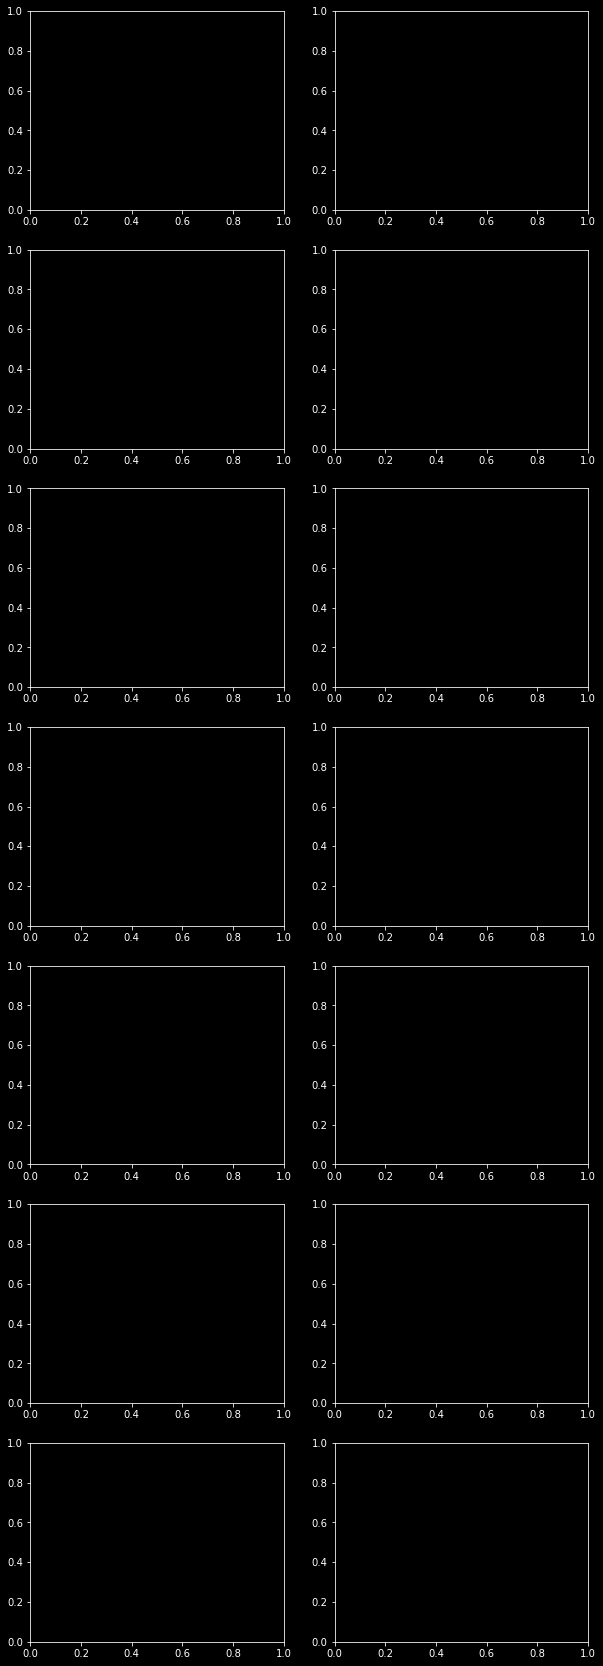

In [69]:
def plot_predictions(res):
    fig, axs = plt.subplots(7,2,figsize=(10,30))
    axs = axs.flatten()

    i = 0
    for key, temp in res.items():
        ax = axs[i]
        years_train = temp['years_train']
        years_test = temp['years_test']
        y_train = temp['y_train']
        y_test = temp['y_test']
        pred = temp['pred']

        ax.plot(years_train, y_train, '*', label = 'train')
        ax.plot(years_test, y_test, '<', label = 'test')
        ax.plot(years_test, pred, 'x', label = 'pred')
        #intercept = temp['intercept_']
        #ax.plot([2013, 2019], [intercept, intercept], '--',
        #        label = 'intercept')
        ax.set_xlim(2012, 2020)
        ax.legend()
        ax.set_title(key)
        ax.set_xlabel('year')
        _ = ax.set_ylabel('severity')
        i +=1

plot_predictions(res)